# Kaggle API


In [ ]:
#!rm -r /root/.kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d jangedoo/utkface-new

100% 330M/331M [00:08<00:00, 43.8MB/s]
100% 331M/331M [00:08<00:00, 39.5MB/s]


In [ ]:
! unzip utkface-new.zip

In [ ]:
#! kaggle datasets list

# GPU

In [1]:
import tensorflow as tf

In [2]:
device_list = tf.test.gpu_device_name()

device_list

'/device:GPU:0'

In [3]:
!nvidia-smi

Sat May  6 18:06:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |    691MiB / 40960MiB |      1%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PACKAGES

In [4]:
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import math
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
def display(img):
    plt.imshow(img)
    plt.show()

def prediction_metrics_age(model, X_test, y_test, classes):
    preds = []
    truth = []
    y_hat = model.predict(X_test)

    for i in range(X_test.shape[0]):
        
        predict_index = np.argmax(y_hat[i])
        preds.append(predict_index) 
        
        true_index = np.argmax(y_test[i])
        truth.append(true_index)
        
    mcc = matthews_corrcoef(truth, preds)
    print("MCC: ", mcc)
    label = list(set(classes))
    cm = confusion_matrix(truth, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(truth, preds))

def prediction_metrics_gender(model, X_test, y_test, classes):

  y_hat = model.predict(X_test)
  y_hat = np.round(y_hat)   

  mcc = matthews_corrcoef(y_test, y_hat)
  print("MCC: ", mcc)
  label = list(set(classes))
  cm = confusion_matrix(y_test, y_hat)
  sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()
  print(classification_report(y_test, y_hat))

In [6]:
#path server
#path = "/UTKFace/"
#path colab
path = "/content/utkface_aligned_cropped/UTKFace"
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
#path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
1_0_0_20170110213012671.jpg.chip.jpg


# DATA NORM

In [13]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 20000:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

# DISTRIBUTIONS

In [15]:
img_all = pd.DataFrame()
img_all["age"] = age_classes
img_all["gender"] = genders

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = age_classes

print("age\n", img_age.age.value_counts())
print("gender\n", img_gender.gender.value_counts())

age
 4    7751
3    6615
5    2256
1    1968
0     919
2     491
Name: age, dtype: int64
gender
 0    10459
1     9541
Name: gender, dtype: int64


## Ages

<ipython-input-11-6047e2ead716>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ages)


<Axes: ylabel='Density'>

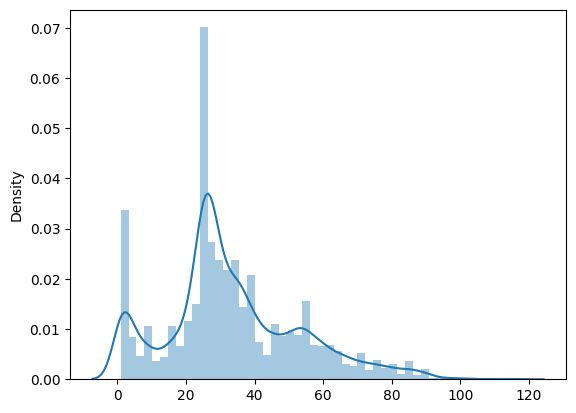

In [11]:
sns.distplot(ages)

## Age Classes

In [12]:
print(len(age_classes))
print(type(age_classes))
unique_values = list(set(age_classes))
print(unique_values)

20000
<class 'list'>
[0, 1, 2, 3, 4, 5]


<ipython-input-13-083d45ced2fd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(age_classes)


<Axes: ylabel='Density'>

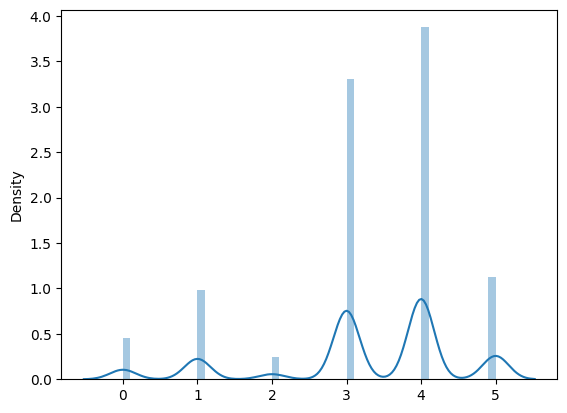

In [13]:
sns.distplot(age_classes)

## Gender

<ipython-input-14-3cfed0c9c84f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(genders)


<Axes: ylabel='Density'>

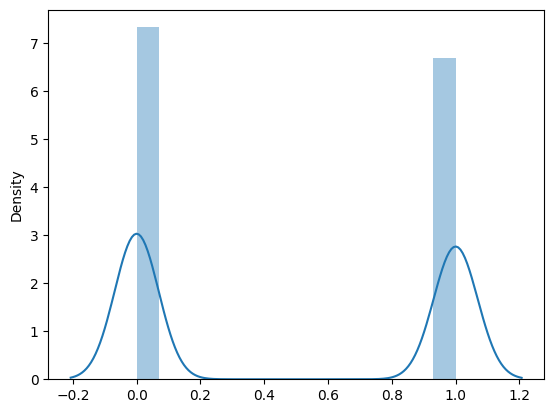

In [14]:
sns.distplot(genders)

# MODELS

In [16]:
def CNN (input_shape, output, activation):
    
    model = tf.keras.Sequential()

    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = input_shape)) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(output, activation=activation))
    
    model.summary()
    
    return model

#otimizar 2k
#adicionar mais conv?
#Dropout antes do flaten apenas
#Mexer otimizador (lr)
#implementar early stoping (). Early Stoping tem patience: e.g., 10 epcohs, ele espera 10 epochs antes de parar.
#ir gravando cnn no servidor

## BASE

### Gender

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [17]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [18]:
model = CNN((200,200,3), 1, 'sigmoid')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [19]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history_base_gender = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 19s 16ms/step - loss: 0.4455 - accuracy: 0.7905 - val_loss: 0.3297 - val_accuracy: 0.8470
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.3221 - accuracy: 0.8601 - val_loss: 0.2983 - val_accuracy: 0.8630
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2785 - accuracy: 0.8787 - val_loss: 0.2730 - val_accuracy: 0.8767
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2557 - accuracy: 0.8906 - val_loss: 0.2655 - val_accuracy: 0.8835
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2298 - accuracy: 0.9018 - val_loss: 0.2489 - val_accuracy: 0.8898
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2066 - accuracy: 0.9150 - val_loss: 0.2550 - val_accuracy: 0.8917
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1838 - accuracy: 0.9232 - val_loss: 0.2757 - val_accuracy: 0.889

125/125 [==============================] - 1s 6ms/step
MCC:  0.7774758026801548


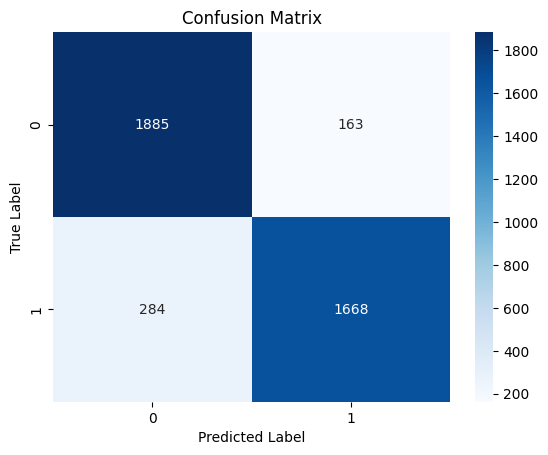

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2048
           1       0.91      0.85      0.88      1952

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



In [40]:
prediction_metrics_gender(model, X_test, y_test, genders)

### Age

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size = 0.2, shuffle = True)

In [18]:
model = CNN((200,200,3), 6, 'softmax')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [19]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_test, y_test),)

Epoch 1/20
500/500 [==============================] - 19s 16ms/step - loss: 1.2224 - accuracy: 0.4921 - val_loss: 0.9508 - val_accuracy: 0.6133
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.9826 - accuracy: 0.5855 - val_loss: 0.8381 - val_accuracy: 0.6467
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.8909 - accuracy: 0.6209 - val_loss: 0.8098 - val_accuracy: 0.6587
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.8300 - accuracy: 0.6478 - val_loss: 0.7941 - val_accuracy: 0.6578
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.7793 - accuracy: 0.6621 - val_loss: 0.7597 - val_accuracy: 0.6675
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.7341 - accuracy: 0.6808 - val_loss: 0.7529 - val_accuracy: 0.6693
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.6876 - accuracy: 0.6990 - val_loss: 0.7671 - val_accuracy: 0.682

125/125 [==============================] - 1s 6ms/step
MCC:  0.5391810072276609


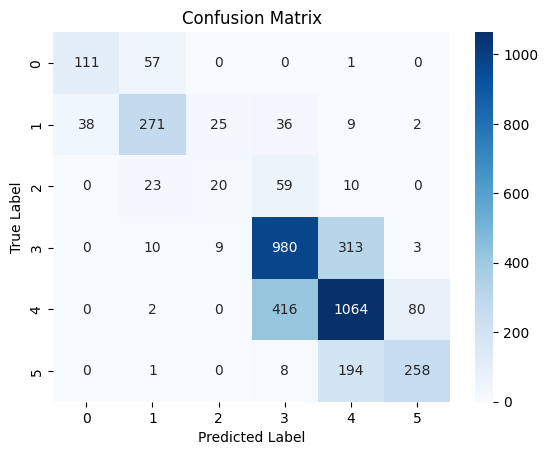

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       169
           1       0.74      0.71      0.73       381
           2       0.37      0.18      0.24       112
           3       0.65      0.75      0.70      1315
           4       0.67      0.68      0.67      1562
           5       0.75      0.56      0.64       461

    accuracy                           0.68      4000
   macro avg       0.66      0.59      0.61      4000
weighted avg       0.68      0.68      0.67      4000



In [20]:
prediction_metrics_age(model, X_test, y_test, age_classes)

# DATA NOT NORM

In [25]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 20000:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        #image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

In [26]:
### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


In [27]:
img_all = pd.DataFrame()
img_all["age"] = age_classes
img_all["gender"] = genders

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = age_classes

print("age\n", img_age.age.value_counts())
print("gender\n", img_gender.gender.value_counts())

age
 4    7751
3    6615
5    2256
1    1968
0     919
2     491
Name: age, dtype: int64
gender
 0    10459
1     9541
Name: gender, dtype: int64


## HOG

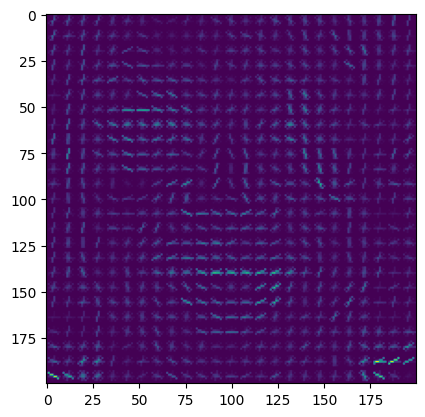

In [28]:
image_check = images[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

In [29]:
# Extract HOG features from the images
hog_features = []
for img in images:
    #hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
    #                cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

### Gender

In [30]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))


cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 144, 144, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 144, 144, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 72, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 64)       

In [32]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)

In [33]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [34]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_hog_gender = cnn.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 5s 6ms/step - loss: 0.6844 - accuracy: 0.5460 - val_loss: 0.6447 - val_accuracy: 0.5263
Epoch 2/20
500/500 [==============================] - 3s 5ms/step - loss: 0.6067 - accuracy: 0.6380 - val_loss: 0.5309 - val_accuracy: 0.7573
Epoch 3/20
500/500 [==============================] - 3s 5ms/step - loss: 0.5435 - accuracy: 0.7129 - val_loss: 0.4926 - val_accuracy: 0.7730
Epoch 4/20
500/500 [==============================] - 3s 5ms/step - loss: 0.5049 - accuracy: 0.7379 - val_loss: 0.4274 - val_accuracy: 0.8012
Epoch 5/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4837 - accuracy: 0.7492 - val_loss: 0.4117 - val_accuracy: 0.8062
Epoch 6/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4611 - accuracy: 0.7598 - val_loss: 0.3954 - val_accuracy: 0.8150
Epoch 7/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4402 - accuracy: 0.7702 - val_loss: 0.4355 - val_accuracy: 0.7812
Epoch 

125/125 [==============================] - 0s 2ms/step
MCC:  0.646466507179876


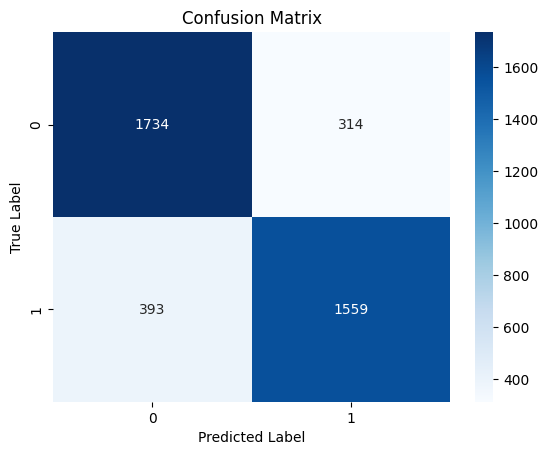

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2048
           1       0.83      0.80      0.82      1952

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



In [35]:
prediction_metrics_gender(cnn, X_test, y_test, genders)

### Age

In [36]:
cnn = Sequential()

cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 144, 144, 1)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 72, 72, 1)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 64)      

In [37]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, age_categories, test_size = 0.2,shuffle = True)

In [38]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [39]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_hog_age = cnn.fit(X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_test, y_test),)

Epoch 1/20
500/500 [==============================] - 4s 6ms/step - loss: 1.2797 - accuracy: 0.4564 - val_loss: 1.0756 - val_accuracy: 0.5508
Epoch 2/20
500/500 [==============================] - 2s 5ms/step - loss: 1.0653 - accuracy: 0.5458 - val_loss: 1.0052 - val_accuracy: 0.5770
Epoch 3/20
500/500 [==============================] - 2s 5ms/step - loss: 0.9732 - accuracy: 0.5908 - val_loss: 0.9589 - val_accuracy: 0.5813
Epoch 4/20
500/500 [==============================] - 2s 5ms/step - loss: 0.8883 - accuracy: 0.6198 - val_loss: 1.0206 - val_accuracy: 0.5512
Epoch 5/20
500/500 [==============================] - 2s 5ms/step - loss: 0.7969 - accuracy: 0.6572 - val_loss: 0.9834 - val_accuracy: 0.5723
Epoch 6/20
500/500 [==============================] - 2s 5ms/step - loss: 0.7019 - accuracy: 0.6966 - val_loss: 1.0633 - val_accuracy: 0.5803
Epoch 7/20
500/500 [==============================] - 2s 5ms/step - loss: 0.6045 - accuracy: 0.7400 - val_loss: 1.1145 - val_accuracy: 0.5828
Epoch 

125/125 [==============================] - 0s 2ms/step
MCC:  0.3529202726185142


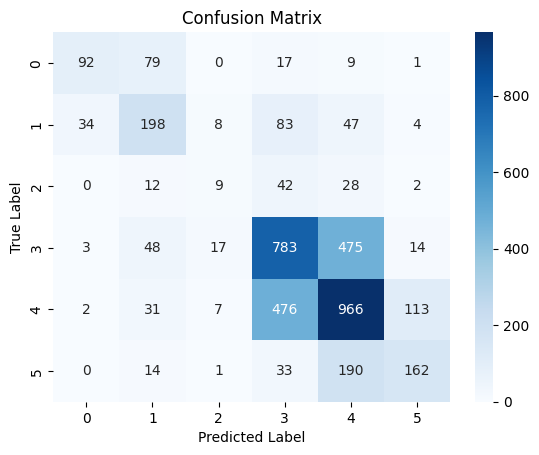

              precision    recall  f1-score   support

           0       0.70      0.46      0.56       198
           1       0.52      0.53      0.52       374
           2       0.21      0.10      0.13        93
           3       0.55      0.58      0.56      1340
           4       0.56      0.61      0.58      1595
           5       0.55      0.41      0.47       400

    accuracy                           0.55      4000
   macro avg       0.52      0.45      0.47      4000
weighted avg       0.55      0.55      0.55      4000



In [40]:
prediction_metrics_age(cnn, X_test, y_test, age_classes)

## ORB

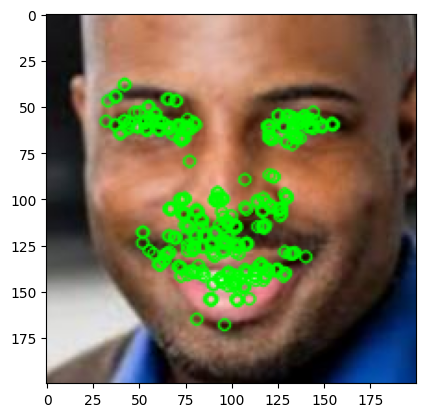

In [41]:
image_check = images[1]

orb = cv2.ORB_create()

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [42]:
image_check = images[1]

orb = cv2.ORB_create()
# define minimum and maximum keypoints
MIN_KEYPOINTS = 100
orb_features = []
orb_genders = []
orb_ages = []

# loop over images and keypoints
for i, img in enumerate(images):
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints)
    keypoints = list(keypoints)    
    # check if number of keypoints is between min and max
    if len(keypoints) < MIN_KEYPOINTS:
        continue
        
    # remove extra keypoints randomly
    while len(keypoints) > MIN_KEYPOINTS:
        idx = random.randint(0, len(keypoints)-1)
        keypoints.pop(idx)
        descriptors = np.delete(descriptors, idx, axis=0)
        
    # add descriptors to feature list
    orb_features.append(np.ndarray.flatten(descriptors))
    orb_genders.append(genders[i])
    orb_ages.append(age_categories[i])

In [43]:
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

### Gender 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_genders, test_size=0.20, random_state=42)

In [45]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [46]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(Flatten())
cnn.add(layers.Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 50, 64, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 64, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 32, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 16, 64)       

In [47]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/20
298/298 [==============================] - 4s 6ms/step - loss: 0.6915 - accuracy: 0.5327 - val_loss: 0.6789 - val_accuracy: 0.5609
Epoch 2/20
298/298 [==============================] - 1s 5ms/step - loss: 0.6795 - accuracy: 0.5756 - val_loss: 0.6695 - val_accuracy: 0.5832
Epoch 3/20
298/298 [==============================] - 2s 5ms/step - loss: 0.6683 - accuracy: 0.5996 - val_loss: 0.6504 - val_accuracy: 0.6235
Epoch 4/20
298/298 [==============================] - 1s 5ms/step - loss: 0.6532 - accuracy: 0.6193 - val_loss: 0.6436 - val_accuracy: 0.6353
Epoch 5/20
298/298 [==============================] - 1s 5ms/step - loss: 0.6384 - accuracy: 0.6441 - val_loss: 0.6273 - val_accuracy: 0.6567
Epoch 6/20
298/298 [==============================] - 1s 5ms/step - loss: 0.6174 - accuracy: 0.6634 - val_loss: 0.6163 - val_accuracy: 0.6706
Epoch 7/20
298/298 [==============================] - 1s 5ms/step - loss: 0.5944 - accuracy: 0.6845 - val_loss: 0.6187 - val_accuracy: 0.6761
Epoch 

75/75 [==============================] - 0s 2ms/step
MCC:  0.21880639702229346


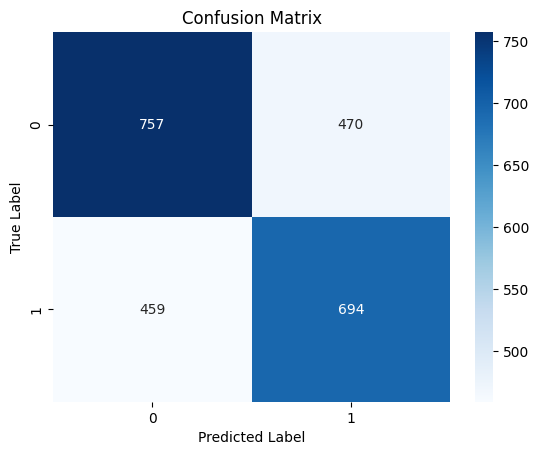

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1227
           1       0.60      0.60      0.60      1153

    accuracy                           0.61      2380
   macro avg       0.61      0.61      0.61      2380
weighted avg       0.61      0.61      0.61      2380



In [48]:
prediction_metrics_gender(cnn, X_test, y_test, orb_genders)

### Age

In [49]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_ages, test_size=0.20, random_state=42)

In [50]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [51]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))


cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(Flatten())

cnn.add(layers.Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

cnn.add(layers.Dense(6, activation='softmax'))

#cnn.summary()

In [52]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/20
298/298 [==============================] - 4s 6ms/step - loss: 0.4340 - accuracy: 0.3222 - val_loss: 0.3910 - val_accuracy: 0.3878
Epoch 2/20
298/298 [==============================] - 2s 5ms/step - loss: 0.3997 - accuracy: 0.3591 - val_loss: 0.3795 - val_accuracy: 0.3807
Epoch 3/20
298/298 [==============================] - 2s 5ms/step - loss: 0.3884 - accuracy: 0.3831 - val_loss: 0.3670 - val_accuracy: 0.4097
Epoch 4/20
298/298 [==============================] - 1s 5ms/step - loss: 0.3785 - accuracy: 0.4037 - val_loss: 0.3677 - val_accuracy: 0.3979
Epoch 5/20
298/298 [==============================] - 1s 5ms/step - loss: 0.3709 - accuracy: 0.4152 - val_loss: 0.3611 - val_accuracy: 0.4286
Epoch 6/20
298/298 [==============================] - 1s 5ms/step - loss: 0.3647 - accuracy: 0.4221 - val_loss: 0.3553 - val_accuracy: 0.4273
Epoch 7/20
298/298 [==============================] - 1s 5ms/step - loss: 0.3584 - accuracy: 0.4395 - val_loss: 0.3563 - val_accuracy: 0.4235
Epoch 

75/75 [==============================] - 0s 2ms/step
MCC:  0.15572991308442352


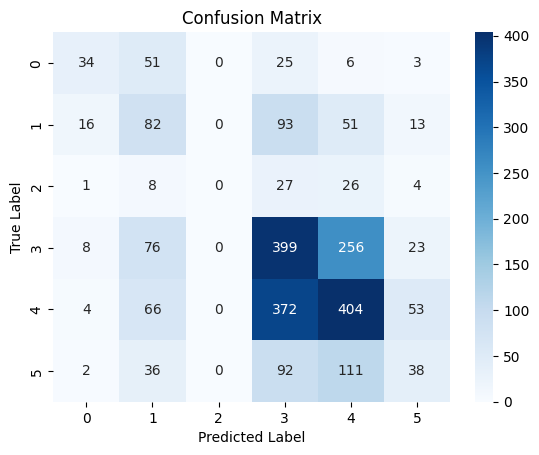

              precision    recall  f1-score   support

           0       0.52      0.29      0.37       119
           1       0.26      0.32      0.29       255
           2       0.00      0.00      0.00        66
           3       0.40      0.52      0.45       762
           4       0.47      0.45      0.46       899
           5       0.28      0.14      0.18       279

    accuracy                           0.40      2380
   macro avg       0.32      0.29      0.29      2380
weighted avg       0.39      0.40      0.39      2380



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
prediction_metrics_age(cnn, X_test, y_test, age_classes)

# DATA NORM

In [7]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 17500:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


## VGG 16

In [8]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
VGG_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [9]:
X = np.stack(images)
X = VGG_model.predict(X)

625/625 [==============================] - 18s 16ms/step


### Gender

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [11]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [15]:
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (6, 6, 512))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    


    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 6, 6, 16)          73744     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 64)               

In [16]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history_VGG16_gender = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 5s 6ms/step - loss: 0.4119 - accuracy: 0.8061 - val_loss: 0.3156 - val_accuracy: 0.8580
Epoch 2/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2819 - accuracy: 0.8821 - val_loss: 0.3098 - val_accuracy: 0.8712
Epoch 3/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2480 - accuracy: 0.8991 - val_loss: 0.2913 - val_accuracy: 0.8745
Epoch 4/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2222 - accuracy: 0.9114 - val_loss: 0.3236 - val_accuracy: 0.8727
Epoch 5/20
500/500 [==============================] - 2s 5ms/step - loss: 0.1927 - accuracy: 0.9252 - val_loss: 0.2879 - val_accuracy: 0.8867
Epoch 6/20
500/500 [==============================] - 2s 5ms/step - loss: 0.1740 - accuracy: 0.9353 - val_loss: 0.3076 - val_accuracy: 0.8852
Epoch 7/20
500/500 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9410 - val_loss: 0.3443 - val_accuracy: 0.8792
Epoch 

125/125 [==============================] - 0s 2ms/step
MCC:  0.7312351287063836


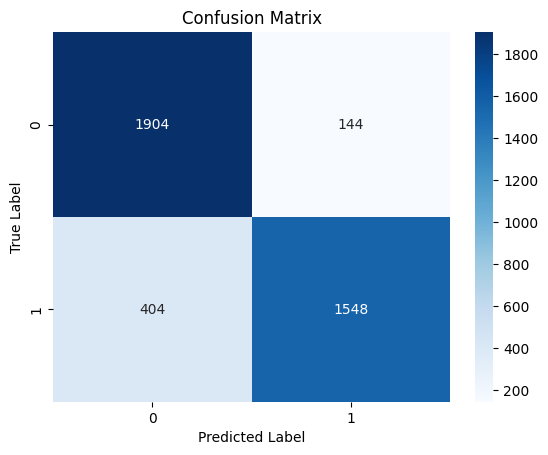

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2048
           1       0.91      0.79      0.85      1952

    accuracy                           0.86      4000
   macro avg       0.87      0.86      0.86      4000
weighted avg       0.87      0.86      0.86      4000



In [17]:
prediction_metrics_gender(model, X_test, y_test, genders)

### Age

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size=0.2, random_state=42)

In [19]:
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (6, 6, 512))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    


    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(6, activation='softmax'))
    
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 6, 6, 16)          73744     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 flatten_2 (Flatten)         (None, 64)               

In [20]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_VGG16_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_test, y_test),)

Epoch 1/20
500/500 [==============================] - 5s 6ms/step - loss: 1.1251 - accuracy: 0.5235 - val_loss: 0.8901 - val_accuracy: 0.6072
Epoch 2/20
500/500 [==============================] - 2s 5ms/step - loss: 0.8734 - accuracy: 0.6294 - val_loss: 0.8192 - val_accuracy: 0.6382
Epoch 3/20
500/500 [==============================] - 2s 5ms/step - loss: 0.7918 - accuracy: 0.6665 - val_loss: 0.7867 - val_accuracy: 0.6587
Epoch 4/20
500/500 [==============================] - 2s 5ms/step - loss: 0.7458 - accuracy: 0.6915 - val_loss: 0.7894 - val_accuracy: 0.6557
Epoch 5/20
500/500 [==============================] - 3s 5ms/step - loss: 0.7005 - accuracy: 0.7034 - val_loss: 0.7774 - val_accuracy: 0.6695
Epoch 6/20
500/500 [==============================] - 2s 5ms/step - loss: 0.6594 - accuracy: 0.7221 - val_loss: 0.7984 - val_accuracy: 0.6610
Epoch 7/20
500/500 [==============================] - 2s 5ms/step - loss: 0.6351 - accuracy: 0.7304 - val_loss: 0.8012 - val_accuracy: 0.6675
Epoch 

125/125 [==============================] - 0s 2ms/step
MCC:  -0.007566287977119093


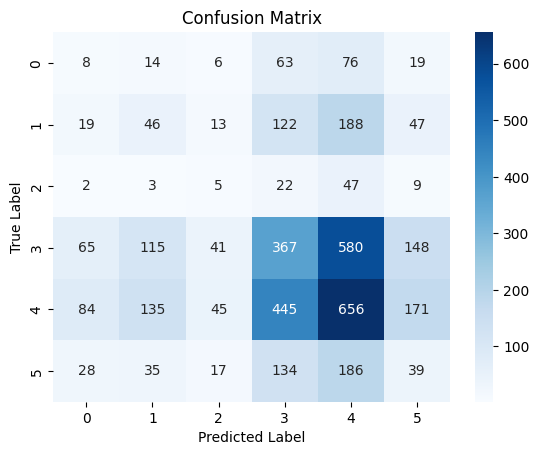

              precision    recall  f1-score   support

           0       0.04      0.04      0.04       186
           1       0.13      0.11      0.12       435
           2       0.04      0.06      0.05        88
           3       0.32      0.28      0.30      1316
           4       0.38      0.43      0.40      1536
           5       0.09      0.09      0.09       439

    accuracy                           0.28      4000
   macro avg       0.17      0.17      0.17      4000
weighted avg       0.28      0.28      0.28      4000



In [21]:
prediction_metrics_age(model, X_test, y_train, age_classes)

## Autoencoder

### Gender

In [22]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [23]:
# binary cross entropy is good for imagprint("Autoencoder Started")
#### AUtoencoder
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)

#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

autoencoder.summary()#e feature extraction especially when images are normalized


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 2000)              20002000  
                                                                 
 dense_7 (Dense)             (None, 10000)             200100

In [24]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 20,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)

Epoch 1/20
500/500 [==============================] - 19s 30ms/step - loss: 0.5908 - accuracy: 0.9220 - val_loss: 0.5665 - val_accuracy: 0.9209
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.5631 - accuracy: 0.9190 - val_loss: 0.5599 - val_accuracy: 0.9242
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.5587 - accuracy: 0.9210 - val_loss: 0.5568 - val_accuracy: 0.9225
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.5564 - accuracy: 0.9238 - val_loss: 0.5554 - val_accuracy: 0.9279
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.5550 - accuracy: 0.9256 - val_loss: 0.5544 - val_accuracy: 0.9317
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.5540 - accuracy: 0.9272 - val_loss: 0.5538 - val_accuracy: 0.9201
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.5533 - accuracy: 0.9282 - val_loss: 0.5529 - val_accuracy:

In [25]:
new_model = Model(input, enc)

encoded_train = new_model.predict(X_train)
encoded_test = new_model.predict(X_test)

encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

125/125 [==============================] - 1s 5ms/step


In [26]:
cnn = Sequential()

# Input shape is (2000,)
cnn.add(layers.Reshape((40, 50, 1), input_shape=encoded_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 40, 50, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 40, 50, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 25, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 12, 64)       

In [27]:
#for age use categorical_crossentropy instead
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_autoencoder_gender = cnn.fit(encoded_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(encoded_test, y_test))

Epoch 1/20
500/500 [==============================] - 4s 5ms/step - loss: 0.5416 - accuracy: 0.7209 - val_loss: 0.4176 - val_accuracy: 0.8120
Epoch 2/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3868 - accuracy: 0.8299 - val_loss: 0.3728 - val_accuracy: 0.8298
Epoch 3/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3381 - accuracy: 0.8531 - val_loss: 0.3448 - val_accuracy: 0.8435
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3068 - accuracy: 0.8654 - val_loss: 0.3267 - val_accuracy: 0.8510
Epoch 5/20
500/500 [==============================] - 2s 4ms/step - loss: 0.2851 - accuracy: 0.8783 - val_loss: 0.3472 - val_accuracy: 0.8472
Epoch 6/20
500/500 [==============================] - 2s 4ms/step - loss: 0.2694 - accuracy: 0.8851 - val_loss: 0.3326 - val_accuracy: 0.8510
Epoch 7/20
500/500 [==============================] - 2s 4ms/step - loss: 0.2499 - accuracy: 0.8900 - val_loss: 0.3665 - val_accuracy: 0.8450
Epoch 

125/125 [==============================] - 0s 2ms/step
MCC:  0.7085630597963958


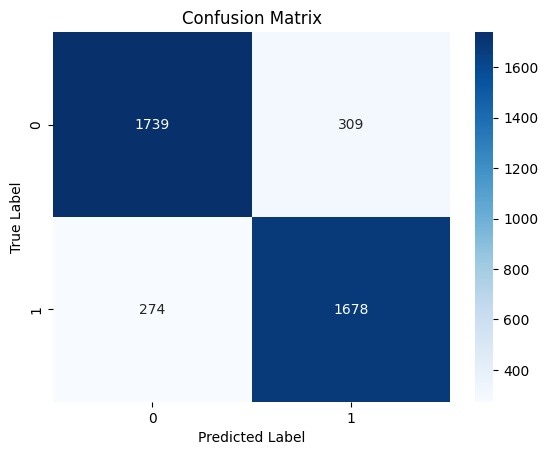

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2048
           1       0.84      0.86      0.85      1952

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



In [28]:
prediction_metrics_gender(cnn, encoded_test, y_test, genders)

### Age

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)

In [9]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [10]:
# binary cross entropy is good for imagprint("Autoencoder Started")
#### AUtoencoder
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)

#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

autoencoder.summary()#e feature extraction especially when images are normalized

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 2000)              20002000  
                                                                 
 dense_1 (Dense)             (None, 10000)             200100

In [11]:
autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 20,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)


Epoch 1/20
438/438 [==============================] - 28s 34ms/step - loss: 0.5950 - accuracy: 0.9218 - val_loss: 0.5676 - val_accuracy: 0.9230
Epoch 2/20
438/438 [==============================] - 9s 21ms/step - loss: 0.5647 - accuracy: 0.9185 - val_loss: 0.5612 - val_accuracy: 0.9133
Epoch 3/20
438/438 [==============================] - 9s 21ms/step - loss: 0.5604 - accuracy: 0.9184 - val_loss: 0.5583 - val_accuracy: 0.9243
Epoch 4/20
438/438 [==============================] - 9s 20ms/step - loss: 0.5577 - accuracy: 0.9219 - val_loss: 0.5565 - val_accuracy: 0.9256
Epoch 5/20
438/438 [==============================] - 9s 21ms/step - loss: 0.5563 - accuracy: 0.9249 - val_loss: 0.5556 - val_accuracy: 0.9254
Epoch 6/20
438/438 [==============================] - 9s 20ms/step - loss: 0.5553 - accuracy: 0.9265 - val_loss: 0.5545 - val_accuracy: 0.9299
Epoch 7/20
438/438 [==============================] - 9s 21ms/step - loss: 0.5544 - accuracy: 0.9276 - val_loss: 0.5538 - val_accuracy: 0.929

In [12]:
new_model = Model(input, enc)
encoded_train = new_model.predict(X_train)
encoded_test = new_model.predict(X_test)

110/110 [==============================] - 1s 5ms/step


In [13]:
encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

In [14]:
cnn = Sequential()

# Input shape is (2000,)
cnn.add(layers.Reshape((40, 50, 1), input_shape=encoded_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(layers.Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 40, 50, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 12, 64)        1

In [15]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_autoencoder_age = cnn.fit(encoded_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(encoded_test, y_test),)

Epoch 1/20
438/438 [==============================] - 6s 6ms/step - loss: 1.3769 - accuracy: 0.4126 - val_loss: 1.1823 - val_accuracy: 0.4974
Epoch 2/20
438/438 [==============================] - 2s 4ms/step - loss: 1.1638 - accuracy: 0.4972 - val_loss: 1.0874 - val_accuracy: 0.5409
Epoch 3/20
438/438 [==============================] - 2s 4ms/step - loss: 1.0617 - accuracy: 0.5417 - val_loss: 0.9968 - val_accuracy: 0.5660
Epoch 4/20
438/438 [==============================] - 2s 4ms/step - loss: 0.9983 - accuracy: 0.5684 - val_loss: 0.9497 - val_accuracy: 0.5943
Epoch 5/20
438/438 [==============================] - 2s 4ms/step - loss: 0.9547 - accuracy: 0.5839 - val_loss: 0.9615 - val_accuracy: 0.5789
Epoch 6/20
438/438 [==============================] - 2s 4ms/step - loss: 0.9167 - accuracy: 0.6040 - val_loss: 0.9519 - val_accuracy: 0.5940
Epoch 7/20
438/438 [==============================] - 2s 4ms/step - loss: 0.8895 - accuracy: 0.6101 - val_loss: 0.9818 - val_accuracy: 0.5937
Epoch 

110/110 [==============================] - 0s 2ms/step
MCC:  0.43390418863859653


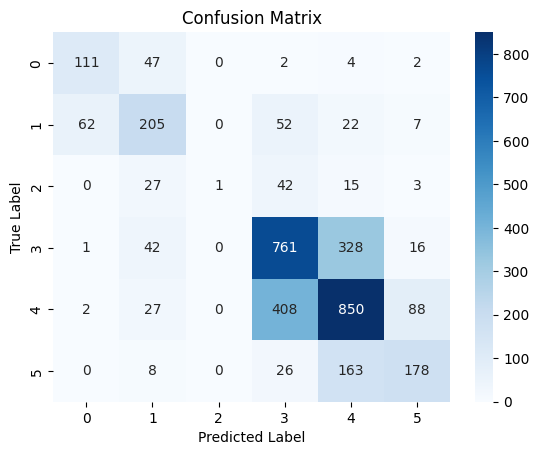

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       166
           1       0.58      0.59      0.58       348
           2       1.00      0.01      0.02        88
           3       0.59      0.66      0.62      1148
           4       0.62      0.62      0.62      1375
           5       0.61      0.47      0.53       375

    accuracy                           0.60      3500
   macro avg       0.67      0.50      0.50      3500
weighted avg       0.61      0.60      0.59      3500



In [16]:
prediction_metrics_age(cnn, encoded_test, y_test, age_classes)